In [1]:
#google colabon:
#from keras.utils import plot_model
#plot_model(model)

load = False

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Dense, Input, LSTM, Concatenate
from keras.models import Model
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from sklearn.decomposition import PCA

from keras.utils import plot_model

RDKit WARNING: [11:56:25] Enabling RDKit 2019.09.1 jupyter extensions
Using TensorFlow backend.
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

# SMILES dataset

In [2]:
# beolvasás és train-test bontás
smifile = "gdb11_size08.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print("Train size: ",smiles_train.shape)
print("Test size",smiles_test.shape)

Train size:  (50029,)
Test size (16677,)


In [3]:
# összes szereplő karakter + kezdő ! + végződés E
charset = set("".join(list(data.smiles))+"!E")
# konvertálás katrakter és sorszáma között
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# beágyazás mérete: leghosszabb szó +5
embed = max([len(smile) for smile in data.smiles]) + 5
print("Lehetséges karakterek:")
print(str(charset))
print("Karakterek száma: ",len(charset),", beágyazás hossza: ", embed)

Lehetséges karakterek:
{'F', 'O', '3', 'H', '!', ']', '1', '-', '+', 'o', 'N', ')', '=', '4', 'C', '[', 'c', 'n', '#', '2', '(', 'E'}
Karakterek száma:  22 , beágyazás hossza:  28


N#CC#CC1COC1
(50029, 27, 22)


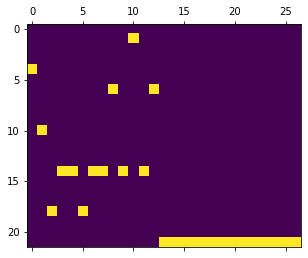

In [4]:
def vectorize(smiles):
    # mérete: (input SMILESok száma x egy reprezentáció hossza x egy karakter one-hotja)
    one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
    for i,smile in enumerate(smiles):
        #START (a 0. !)
        one_hot[i,0,char_to_int["!"]] = 1
        #karakterek kódja
        for j,c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        #END (a végéig E karakterrel lesz kitöltve)
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # X: !... Y: ...E
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
# egy smiles feldolgozás előtt
print(smiles_train.iloc[0])
# feldolgozás után: !N#...EEEEEE
plt.matshow(X_train[0].T)
# train_size x embed-1 x karakter hossz
print(X_train.shape)

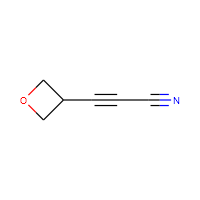

In [5]:
Draw.MolsToImage(smiles_train.iloc[0:1].apply(Chem.MolFromSmiles))

# AE MODEL

In [6]:
# 27 x 22 (27 karakter, 1 karakter 22 féle lehet)
input_shape = X_train.shape[1:]
# 22 (egy karakter)
output_dim = Y_train.shape[-1]
# látens dimenzió
latent_dim = 64
# LSTM cellák száma
lstm_dim = 64

## ENCODER: input -> h,c

In [7]:
unroll = False
encoder_inputs = Input(shape=input_shape, name='encoder_input')
encoder = LSTM(lstm_dim, return_state=True,unroll=unroll)
# 64 LSTM cella tanul rajta, a kimenet nem számít, a rejtett állapotok konkatenáltja lesz a bottleneck
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
# látens reprezentáció, látens dimenzió hosszú
neck_outputs = neck(states)

Instructions for updating:
Colocations handled automatically by placer.


## DECODER: input+h+c -> output

In [8]:
# a látens reprezentációból visszaalakítja a h és c állapotokat
decode_h =  Dense(lstm_dim, activation="relu")
decode_c =  Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]

# az enkóder LST újra megkapja az inputot, a következő karaktert kell kitalálnia, az egész kimeneti karaktersorozattal tér vissza
# pl a két állapotból és a !-ből kell kitalálnia az első karaktert
# de nem a saját outputját kell tovább vinnie, hanem minden karaktert a bemenet alapján (teacher enforcing)
decoder_inputs = Input(shape=input_shape, name='decoder_input')
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# ez becsli a karaktert minden lépés után
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## AE

In [9]:
#Inputként kétszer kapja meg a sztringeket
# enkóder része előállítja az input alapján kiszámolt állapotok tömörített vektorát
# a dekóder ezekből az állapotokból próbálja rekonstruálni az eredeti inputot
#   teacher enforcing miatt neki is megadjuk, hogy mi volt az eredeti, így a következő karaktert nem a saját előzőjéből, hanem az eredeti előzőből kell becsülnie
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 27, 22)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  22272       encoder_input[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]              
__________

## AE PRETRAIN

In [10]:
h = History()
# akkor csökkenti a learning ratet, ha 10 epoch után se csökken a val_loss jelentősen
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

# 200 epochig is mehet
# bemenet: !abcEE
# ebből kell becsülnie: abcEEE
opt=Adam(lr=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')
    
if (load):
    model.load_weights('ae_SMILES.h5')
else:
    model.fit([X_train,X_train],Y_train,
              epochs=50,
              batch_size=256,
              shuffle=True,
              callbacks=[h, rlr],
              validation_data=[[X_test,X_test],Y_test ])
    model.save_weights('ae_SMILES.h5')

Instructions for updating:
Use tf.cast instead.


C:\Conda\envs\Tensorflow-GPU\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 50029 samples, validate on 16677 samples
Epoch 1/50
50029/50029 [==============================] - 32s 647us/step - loss: 0.8979 - val_loss: 0.6527
Epoch 2/50
50029/50029 [==============================] - 25s 508us/step - loss: 0.6068 - val_loss: 0.5710
Epoch 3/50
50029/50029 [==============================] - 25s 504us/step - loss: 0.5616 - val_loss: 0.5412
Epoch 4/50
50029/50029 [==============================] - 23s 465us/step - loss: 0.5293 - val_loss: 0.5151
Epoch 5/50
50029/50029 [==============================] - 23s 455us/step - loss: 0.5011 - val_loss: 0.4608
Epoch 6/50
50029/50029 [==============================] - 22s 449us/step - loss: 0.4277 - val_loss: 0.3948
Epoch 7/50
50029/50029 [==============================] - 22s 448us/step - loss: 0.3740 - val_loss: 0.3389
Epoch 8/50
50029/50029 [==============================] - 25s 493us/step - loss: 0.3288 - val_loss: 0.3132
Epoch 9/50
50029

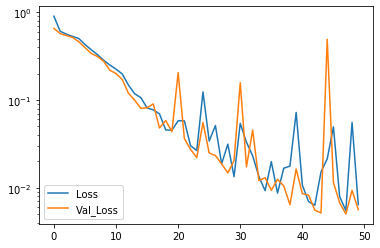

In [11]:
if (not load):
    # loss és val loss logaritmikus skálán
    plt.plot(h.history["loss"], label="Loss")
    plt.plot(h.history["val_loss"], label="Val_Loss")
    plt.yscale("log")
    plt.legend()

# SAMPLING MODEL

## SMILES -> latent

In [12]:
# !abcEE -> dense([h,c])
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
if (load):
    smiles_to_latent_model.load_weights("smi2lat.h5")

## latent -> states

In [13]:
latent_input = Input(shape=(latent_dim,))
#a már betanult konvertálókat használja
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
# dense([h,c]) -> [h', c']
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
if (load):
    latent_to_states_model.load_weights("lat2state.h5")

## state -> SMILES

In [14]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
#batchek között átadódik az utolsó state
inf_decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll, stateful=True)
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
# [h,c] -> karakter 
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

# súlyok öröklése az előző modell dekóderjéből, most csak így lehet, mert új LSTM réteget kellett hozádni ami már stateful
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())

if (load):
    sample_model.load_weights("samplemodel.h5")
    
sample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 1, 22)                0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                22272     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 22)                1430      
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


# LATENT SPACE

In [15]:
# tesztadatok leképezése látens térbe
x_latent = smiles_to_latent_model.predict(X_test)

In [16]:
# adott sorszámú molekula leképezése
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
# 10 a látens térben legközelebb elhelyezkedő molekula
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))

print("Original: ", smiles_test.iloc[molno])
print("Similar:")
print(smiles_test.iloc[sorti[1:10]])


Original:  COCc1cocn1
Similar:
53382     COC(=CF)C1CN1
53390     OCC(=CF)C1CO1
45061        COCc1conn1
45020        OCCc1cnoc1
53275     OCC(C#C)C1CO1
46192     CC=C(F)C1OC1C
27474       COCC(CF)=NO
59254     OCC=C(F)C1CN1
29970    OCC(=CF)C(O)=O
Name: smiles, dtype: object


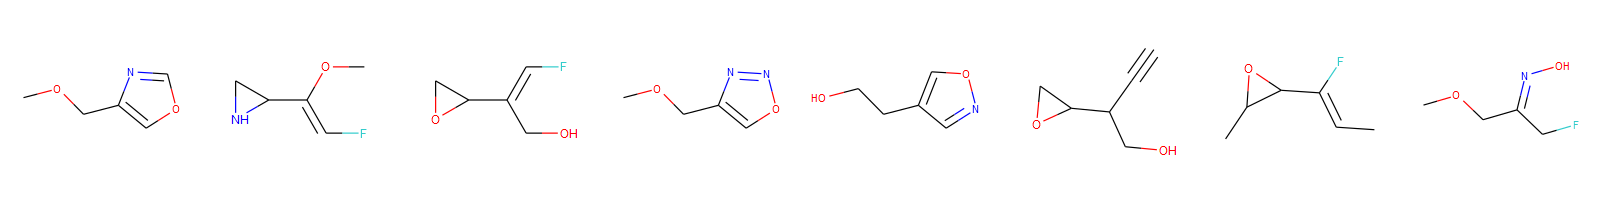

In [17]:
# 8 leghasonlóbb molekula kirajzolása
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

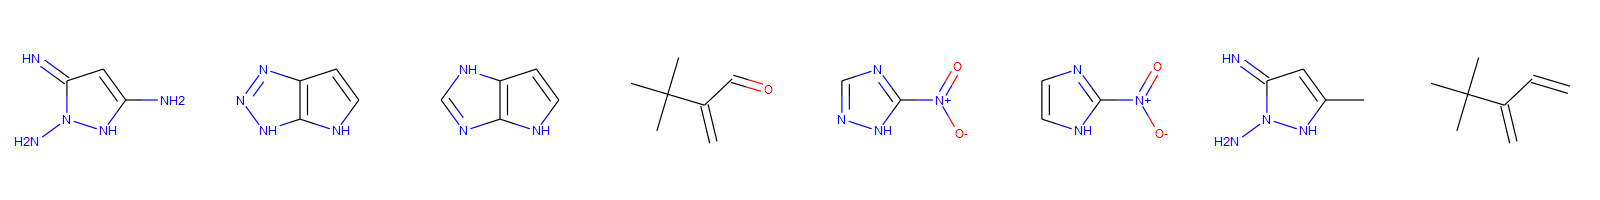

In [18]:
# 8 legeltérőbb
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

[0.2742039 0.1771059] 0.4513098


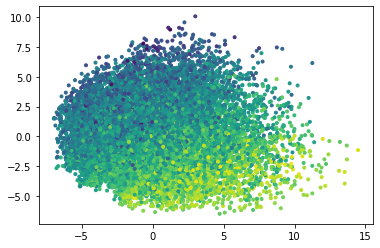

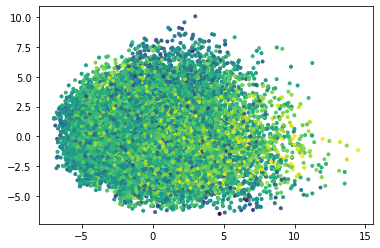

In [19]:
# logp és molwt tujaldonságok leképzése látens térben
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)

plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [20]:
#szekvenciális modell a látens térbeli reprezentációból képes megtanulni a logP tulajdonságot
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=200, callbacks = [rlr])

C:\Conda\envs\Tensorflow-GPU\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/200
50029/50029 [==============================] - 2s 48us/step - loss: 0.2176
Epoch 2/200
 4480/50029 [=>............................] - ETA: 1s - loss: 0.1907

C:\Conda\envs\Tensorflow-GPU\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50029/50029 [==============================] - ETA: 0s - loss: 0.182 - 2s 35us/step - loss: 0.1830
Epoch 3/200
50029/50029 [==============================] - 2s 37us/step - loss: 0.1700
Epoch 4/200
50029/50029 [==============================] - 2s 43us/step - loss: 0.1646
Epoch 5/200
50029/50029 [==============================] - 2s 37us/step - loss: 0.1553
Epoch 6/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.1541
Epoch 7/200
50029/50029 [==============================] - 3s 51us/step - loss: 0.1485
Epoch 8/200
50029/50029 [==============================] - 3s 51us/step - loss: 0.1447
Epoch 9/200
50029/50029 [==============================] - 2s 45us/step - loss: 0.1432
Epoch 10/200
50029/50029 [==============================] - 2s 42us/step - loss: 0.1408
Epoch 11/200
50029/50029 [==============================] - 2s 45us/step - loss: 0.1356
Epoch 12/200
50029/50029 [==============================] - 3s 56us/step - loss: 0.1342
Epoch 13/200
50029/50029 [==

50029/50029 [==============================] - 2s 36us/step - loss: 0.0630
Epoch 187/200
50029/50029 [==============================] - 2s 37us/step - loss: 0.0645
Epoch 188/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0631
Epoch 189/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0633
Epoch 190/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0635
Epoch 191/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0636
Epoch 192/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0623
Epoch 193/200
50029/50029 [==============================] - 2s 35us/step - loss: 0.0625
Epoch 194/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0628
Epoch 195/200
50029/50029 [==============================] - 2s 37us/step - loss: 0.0639
Epoch 196/200
50029/50029 [==============================] - 2s 36us/step - loss: 0.0620
Epoch 197/200
50029/50029 [========

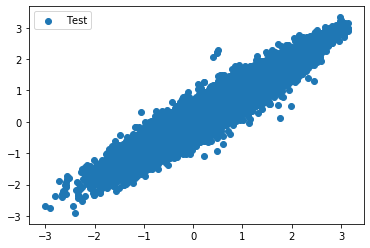

In [28]:
# egyes logP értékekre miket predikált
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.legend()

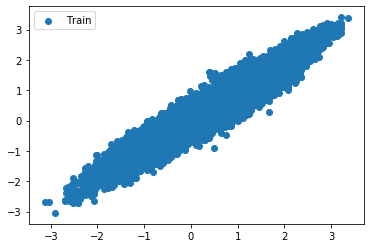

In [29]:
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

# GENERATE

In [22]:
# látens -> smiles
def latent_to_smiles(latent):
    #látens tér -> állapotok -> LSTM állapotainak visszaállítása
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #első karakter a !
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""

    for i in range(28):
        # mintavételezett karakter az előző alapján
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        # ha nincs vége, következő karakter előkészítése, kimenet hozzáfűzése
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [23]:
# pl adott smiles reprezentációjából képes visszaállítani ugyanazt a smilest
smiles = latent_to_smiles(x_latent[0:1])
print(smiles)
print(smiles_test.iloc[0])

NCCC1OC=NO1
NCCC1OC=NO1


In [24]:
# letesztelni, hogy hány százaléka a generáltnak nincs jó smiles formátumban
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

O1CC=N1C(CO)CN
C1=C(C1)n2cnc[nH]2
CC(C=C(CF)C#C
NC1CN=CN2CO12
FC1CNN1(C)C=O
Nc1n[nH]nn1C#N
O=C1CC2(CNOC1=N
C=C1CN(C)=COC1
0.8 percent wrongly formatted smiles


NCCC1=OCNC1
NCCC1=OCNC1
NCCC1=OCNC1
CN#CC1CN1=NO
CN#CC1=NOCN1
CN#CC1=NOCN1
COC=C1=NOCCN1
C=C1COCN=C2C12
C=C1COCN=C2N1
C=C1COCN=C2N1
C=C1COCN=C2N1


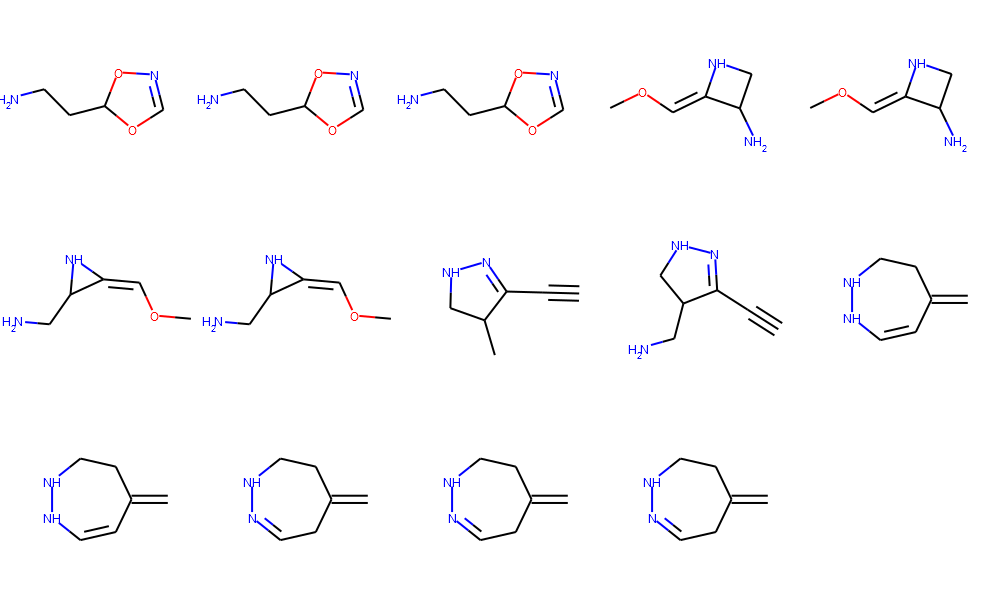

In [25]:
#Látens térbeli interpoláció tesztelése
# ha lehet akkor kirajzolja, ha nem akkor csak kiírja a sztringet
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

CNOCCC1C#N
NCCCO1NC=C1
NCC#CC1NO1C
NCCC1N1C(F)O


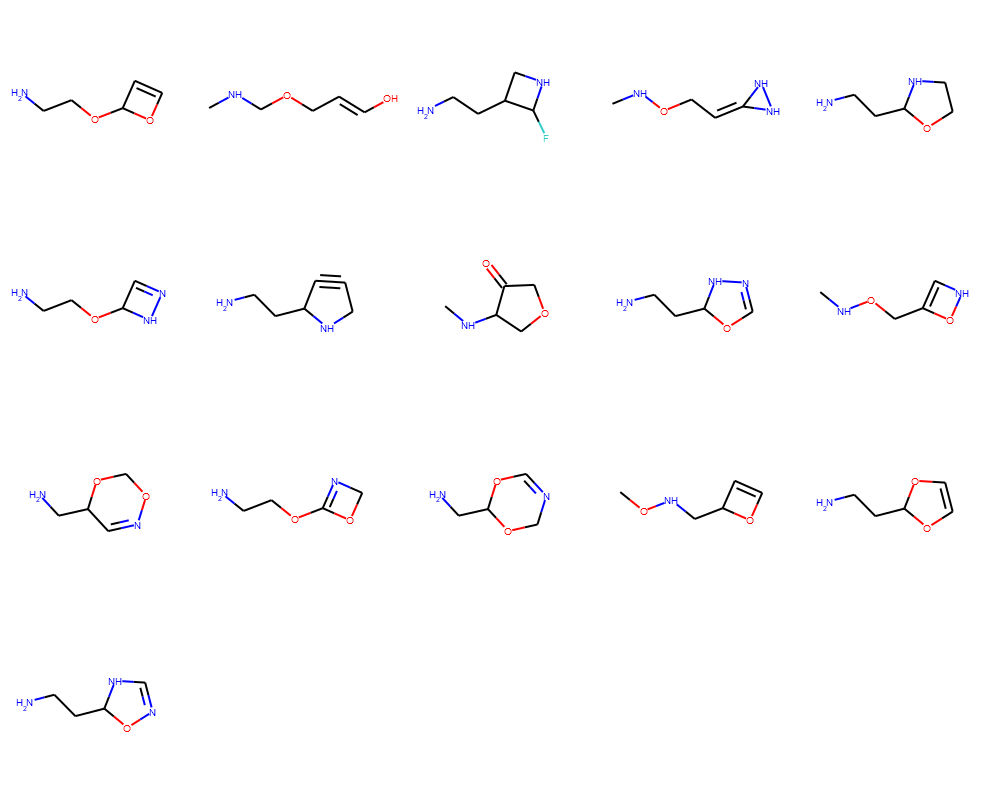

In [30]:
#egy adott látens vektor körül mintavételezünk, megnézzük, hogy valid-e, és mennyire tér el
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1]))
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)

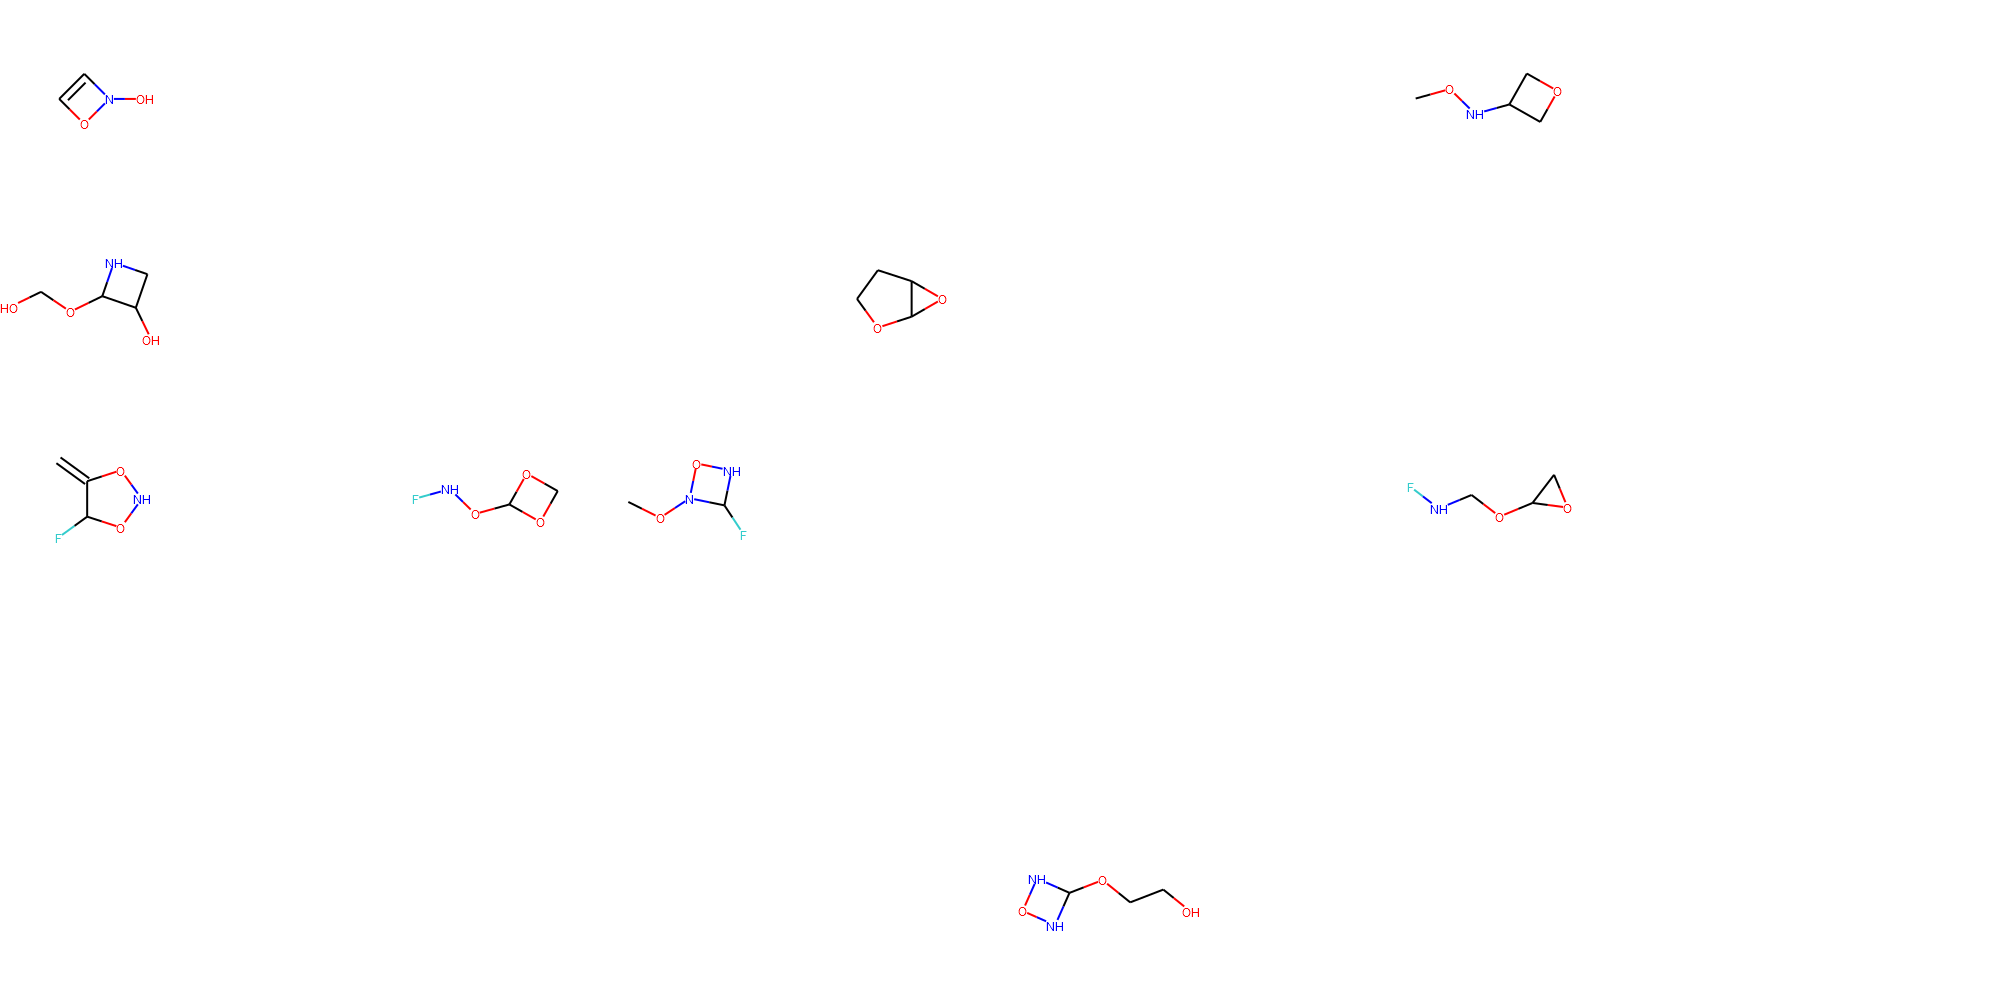

In [54]:
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]
#látens térből generálás
mols1 = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        latent = np.random.normal(0.0, 1, (1,latent_dim))
        latent[0,0]=xi
        latent[0,1]=yi
        smiles  = latent_to_smiles(latent)
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols1.append(mol)
        else:
            mols1.append(Chem.MolFromSmiles(""))
Draw.MolsToGridImage(mols1, molsPerRow=10)